<IPython.core.display.Javascript object>


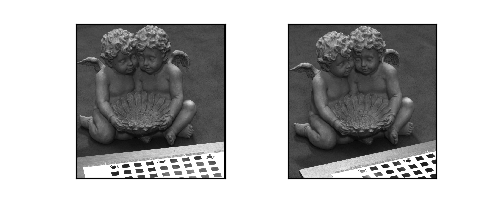

In [42]:
%matplotlib notebook
import cv2 as cv
import numpy as np
import random 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = [5,2]

# Uncomment to use Cube, Comment to use Statue
# img1 = cv.imread("data/Mesona1.JPG",0)
# img2 = cv.imread("data/Mesona2.JPG",0)
# K1 = np.array([[1.4219, 0.0005, 0.5092],[0, 1.4219, 0.3802],[0,0,0.0010]])
# K2 = np.array([[1.4219, 0.0005, 0.5092],[0, 1.4219, 0.3802],[0,0,0.0010]])

# Uncomment to use Statue, Comment to use Cube
img1 = cv.imread("data/Statue1.bmp",0)
img2 = cv.imread("data/Statue2.bmp",0)
K1 = np.array([[5426.566895, 0.678017, 330.096680],[0.000000, 5423.133301, 648.950012],[0,0,1]])
K2 = np.array([[5426.566895, 0.678017, 387.430023], [0.000000, 5423.133301,620.616699] , [0,0,1]])

show_img1 = cv.cvtColor(img1, cv.COLOR_GRAY2RGB)
show_img2 = cv.cvtColor(img2, cv.COLOR_GRAY2RGB)
show_comparison_image(show_img1, show_img2)

In [ ]:
def show_image(img):
    plt.figure()
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
def show_comparison_image(img1, img2):
    plt.figure()
    plt.subplot(121)
    plt.imshow(img1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(img2)
    plt.xticks([]), plt.yticks([])
    plt.show()

    
def filter_ratio_matches(matches, kp1, kp2, ratio=0.7):
    new_kp1, new_kp2, new_matches = [], [], []
    ctr = 0
    for i, (m, n) in enumerate(matches):  #
        if m.distance < ratio * n.distance:
            new_kp1.append(kp1[m.queryIdx])
            new_kp2.append(kp2[m.trainIdx])
            new_matches.append([cv.DMatch(ctr, ctr, m.distance)])
            ctr += 1
    return new_matches, new_kp1, new_kp2

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [46]:

sift = cv.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher(cv.NORM_L2)

# For each local descriptor des1, find 2 best correspondence from des 2
matches = bf.knnMatch(des1, des2, k=2)  # Think of it just finding a cluster of ssd.

good = []
pts1 = []
pts2 = []

mask = [[0,0]] * len(matches)

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        mask[i] = [1,0]


pts1 = np.int32(pts1)
pts2 = np.int32(pts2)


F, mask_F = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC, param1=1)
E, mask_E = cv.findEssentialMat(pts1, pts2)
print("Fundamental Matrix")
print(F)
print("Essential Matrix")
print(E)

# We select only inlier points
pts1 = pts1[mask_F.ravel()==1]
pts2 = pts2[mask_F.ravel()==1]



<IPython.core.display.Javascript object>


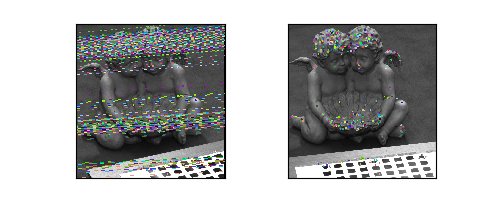

<IPython.core.display.Javascript object>


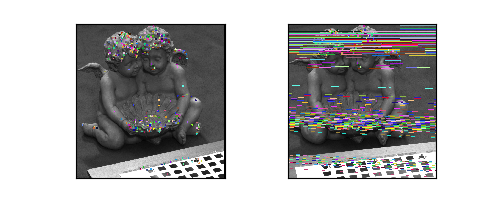

In [54]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

show_comparison_image(img3, img4)
show_comparison_image(img6, img5)

In [55]:
# Compute Essential Matrix from Fundamental Matrix and Intrinsic Matrix
E = np.dot(K2.transpose(), np.dot(F, K1))

def decomposeEssentialMatrix(E):    
    R1,R2,u3 = cv.decomposeEssentialMat(E)
    u3 = u3.transpose()
    return [np.vstack((R1.transpose(), u3)).transpose(), 
            np.vstack((R1.transpose(), -u3)).transpose(),
            np.vstack((R2.transpose(), u3)).transpose(),
            np.vstack((R2.transpose(), -u3)).transpose()]

all_p2_solutions = decomposeEssentialMatrix(E)

In [56]:
def triangulatePoint(point_1, point_2, p1, p2):
    # define A
    u1, v1 = point_1[0], point_1[1]
    u2, v2 = point_2[0], point_2[1]
    
    A= np.zeros((4,4))
    
    A[0] = u1*p1[2] - p1[0]
    A[1] = v1*p1[2] - p1[1]
    A[2] = u2*p2[2] - p2[0]
    A[3] = v2*p2[2] - p2[1]
    
    u,s,v = np.linalg.svd(A)
    x = v[-1]
    x = x / x[-1]
    return x

def triangulate(pts1, pts2, p1, p2):
    R1,t1 = getRmatAndTmat(p1)
    R2,t2 = getRmatAndTmat(p2)
    
    # compute camera centers
    C1 = -np.dot(R1.transpose(), t1)
    C2 = -np.dot(R2.transpose(), t2)
    
    V1 = np.dot(R1.transpose(), np.array([0,0,1]))
    V2 = np.dot(R2.transpose(), np.array([0,0,1]))
    
    points = []
    for pt1, pt2 in zip(pts1, pts2):
        point_in_3d = triangulatePoint(pt1, pt2, p1, p2)[:3]
        test1 = np.dot((point_in_3d-C1),V1)
        test2 = np.dot((point_in_3d-C2),V2)
        if (test1 > 0 and test2 > 0):
            points.append(point_in_3d)
            
    return np.array(points)

def getRmatAndTmat(p):
    R= p1[:, :3];t = p1[:, 3];
    return R, t

def findCameraMatrix(kp1, kp2, K1, K2, p2_solutions):
    p1 = np.vstack((np.eye(3), np.zeros(3))).transpose()
    p1 = np.dot(K1, p1)
    best_p2 = -1
    best_p2_inliers = -1
    best_p2_points = []
    for sol_p2 in p2_solutions:
        p2 = np.dot(K2, sol_p2)
        points = triangulate(kp1, kp2, p1, p2)
        if (best_p2_inliers < points.shape[0]):
            best_p2_inliers = points.shape[0]
            best_p2 = p2
            best_p2_points = points
    return p1, best_p2, best_p2_points
    

[[5.42656689e+03 6.78017000e-01 3.30096680e+02 0.00000000e+00]
 [0.00000000e+00 5.42313330e+03 6.48950012e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[ 5.40523260e+03  5.53546724e+02 -2.73454408e+02  5.11885992e+03]
 [-4.75916868e+02  5.40080120e+03  6.32763327e+02 -4.55047869e+02]
 [ 1.20944257e-01  9.27364632e-03  9.92615981e-01 -2.66570921e-01]]
(339, 3)


<IPython.core.display.Javascript object>


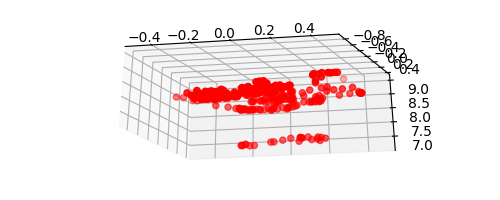

<IPython.core.display.Javascript object>


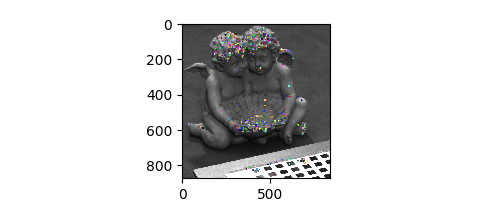

In [58]:
best_p1, best_p2, points = findCameraMatrix(pts1, pts2, K1, K2, all_p2_solutions)

print(best_p1)
print(best_p2)
print(points.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c='r', marker='o')


fig = plt.figure()
plt.imshow(img6)
plt.show()